In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import trange 
from torchvision.datasets.utils import download_and_extract_archive
import torch 
import cv2
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
        
print('libs loaded .........')
device = "cuda:1" if torch.cuda.is_available() else "cpu"
print(device)

libs loaded .........
cuda:1


# Download and load the dataset.

In [2]:
url="http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy"
download_root="dataset"
filename="moving_mnist.npy"
# download_and_extract_archive(url=url, download_root=download_root, filename=filename)
dataset_path = download_root + "/" + filename
dataset = np.load(dataset_path)

# Swap the axes representing the number of frames and number of data samples.
dataset = np.swapaxes(dataset, 0, 1)
# We'll pick out 1000 of the 10000 total examples and use those.
dataset = dataset[:1000, ...]
# Add a channel dimension since the images are grayscale.
dataset = np.expand_dims(dataset, axis=-1)

print(type(dataset))
print("shape of dataset: ", dataset.shape)

<class 'numpy.ndarray'>
shape of dataset:  (1000, 20, 64, 64, 1)


1000 samples or videos.
Each video has 20 frames.
Each frame H=64 X W=64 X 1 channel (grayscale)

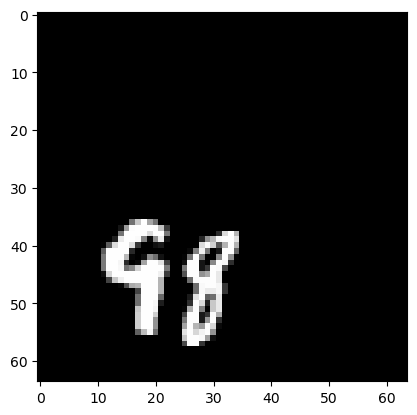

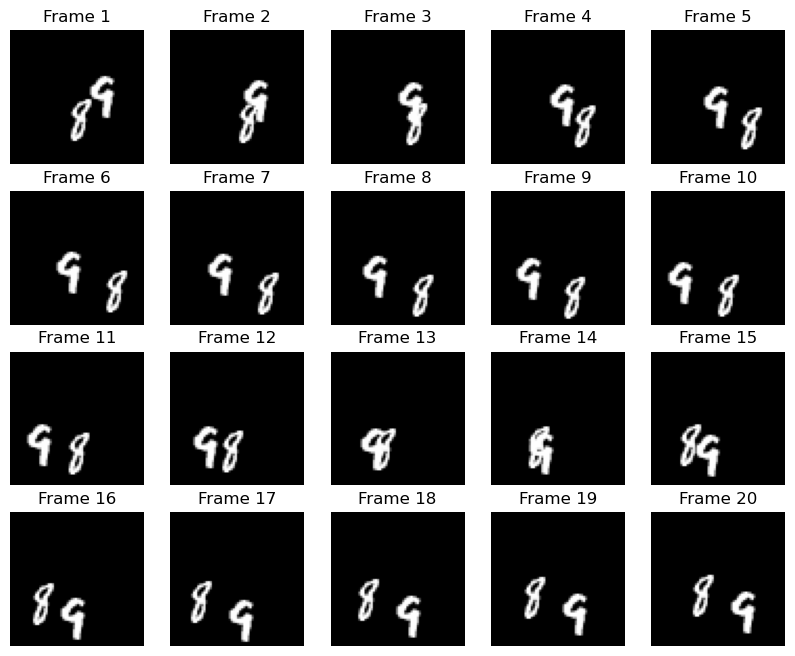

In [3]:

# Display one frame

v = 123 
f = 11

plt.imshow(np.squeeze(dataset[v][f]), cmap="gray")
v = 123 

# Construct a figure on which we will visualize all the frames of one video.
fig, axes = plt.subplots(4, 5, figsize=(10, 8))

for idx, ax in enumerate(axes.flat):
    ax.imshow(np.squeeze(dataset[v][idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

In [4]:


# Print information and display the figure.
print(f"Displaying frames for example {v}.")
plt.show()
# Split into train and validation sets using indexing to optimize memory.
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

# Normalize the data to the 0-1 range.
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255

print('train ' , train_dataset.shape)
print('val ' , val_dataset.shape)

Displaying frames for example 123.
train  (900, 20, 64, 64, 1)
val  (100, 20, 64, 64, 1)


In [5]:

# We'll define a helper function to shift the frames, where form totall 'n' frames,
# we select 'k' frame as input and the next 'm' frame as output.
# Therefore `x` is frames '0' to 'n - m - k + 1', and `y` is frames 'k + 1' to 'n - 1'.
def create_shifted_frames(data, k, m):
    n = data.shape[1] #number of all episode frames = 20
    x, y = [], []
    for i in range(n-m-k+1):
        x.append(data[:, i : i+k , :, :]) 
        y.append(data[:, k+i : k+i+m , :, :])
    return np.squeeze(np.concatenate(x, axis=0),-1), np.squeeze(np.concatenate(y, axis=0),-1)



# Apply the processing function to the datasets.
input_sequence_number = 10 
output_sequence_number = 1

x_train, y_train = create_shifted_frames(train_dataset, input_sequence_number, output_sequence_number)
x_val, y_val = create_shifted_frames(val_dataset, input_sequence_number, output_sequence_number)


# Inspect the dataset.
print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Training Dataset Shapes: (9000, 10, 64, 64), (9000, 1, 64, 64)
Validation Dataset Shapes: (1000, 10, 64, 64), (1000, 1, 64, 64)


Displaying input frames for example 124.


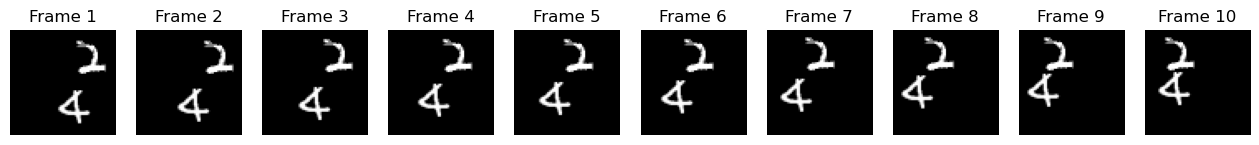

Displaying target frames for example 124.


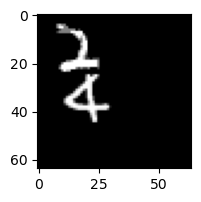

In [6]:

# Construct a figure on which we will visualize the images.
x_fig, x_axes = plt.subplots(1, input_sequence_number, figsize=(16, 12))

# Plot each of the sequential images for one random data example.
data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(x_axes.flat):
    ax.imshow(np.squeeze(x_train[data_choice][idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 1}")
    ax.axis("off")

# Print information and display the figure.
print(f"Displaying input frames for example {data_choice}.")
plt.show()


print(f"Displaying target frames for example {data_choice}.")
y_fig, y_axes = plt.subplots(1, output_sequence_number, figsize=(4, 2))
try:
    for idx, ax in enumerate(y_axes.flat):
        ax.imshow(np.squeeze(y_train[data_choice][idx]), cmap="gray")
        ax.set_title(f"Frame {idx + 1}")
        ax.axis("off")
except:
        y_axes.imshow(np.squeeze(y_train[data_choice]), cmap="gray")
        ax.set_title(f"Frame {0}")
        ax.axis("off")


In [9]:

import torch
from torch.utils.data import Dataset, DataLoader

class LongTermPredictionDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        input_frames = self.x[idx]
        target_frame = self.y[idx]

        return input_frames, target_frame

# Assuming x and y are your input and target data
train_dataset = LongTermPredictionDataset(x_train, y_train)
val_dataset = LongTermPredictionDataset(x_val, y_val)

# You may want to split your dataset into training and validation sets
# For example, using the first 12000 samples for training and the last 1500 for validation
# train_size = 12000
# train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, len(train_dataset) - train_size])

# Define batch size
batch_size = 16

# Create DataLoader instances for training and validation
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
validation_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [9]:

import torch
import torch.nn as nn

# Define the Fully Connected (FC) network
class LongTermPredictionModel(nn.Module):
    def __init__(self):
        super(LongTermPredictionModel, self).__init__()
        self.fc1 = nn.Linear(64 * 64 * input_sequence_number, 2048)
        self.fc2 = nn.Linear(2048, 2048)
        self.fc3 = nn.Linear(2048, 64 * 64 * output_sequence_number)

    def forward(self, x):
        x = x.view(-1, 64 * 64 * input_sequence_number)  # Flatten input
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))  # Using sigmoid for grayscale pixel values (0 to 1)
        return x.view(-1, output_sequence_number, 64, 64)   # Reshape to the frame size

# Instantiate the model
model = LongTermPredictionModel()
# Calculate the number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'Total Number of Parameters in the Model: {total_params}')

# Set random seed for reproducibility
torch.manual_seed(0)

# Instantiate the model
model = LongTermPredictionModel()

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)


Total Number of Parameters in the Model: 96477184


In [39]:

# Number of training epochs
num_epochs = 12

# Training loop
for epoch in trange(num_epochs):
    model.train().to(device)  # Set the model to training mode
    total_loss = 0.0

    for batch_idx, (input_frames, target_frame) in enumerate(train_loader):
        input_frames = input_frames.to(device)
        target_frame = target_frame.to(device)
        optimizer.zero_grad()  # Zero the gradients
        output_frame = model(input_frames)  # Forward pass

        loss = criterion(output_frame, target_frame)  # Compute the loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        total_loss += loss.item()

    # Print training loss for each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader)}')

# Validation loop
model.eval()  # Set the model to evaluation mode
total_val_loss = 0.0

with torch.no_grad():
    for batch_idx, (input_frames, target_frame) in enumerate(validation_loader):
        input_frames = input_frames.to(device)
        target_frame = target_frame.to(device)
        output_frame = model(input_frames)
        val_loss = criterion(output_frame, target_frame)
        total_val_loss += val_loss.item()

# Print validation loss
print(f'Validation Loss: {total_val_loss / len(validation_loader)}')

  8%|▊         | 1/12 [00:06<01:13,  6.67s/it]

Epoch [1/12], Loss: 0.0015393459340441455


 17%|█▋        | 2/12 [00:13<01:06,  6.65s/it]

Epoch [2/12], Loss: 0.0014690372442869714


 25%|██▌       | 3/12 [00:19<00:59,  6.63s/it]

Epoch [3/12], Loss: 0.001408864423140446


 33%|███▎      | 4/12 [00:26<00:53,  6.64s/it]

Epoch [4/12], Loss: 0.0013487004418940253


 42%|████▏     | 5/12 [00:33<00:46,  6.64s/it]

Epoch [5/12], Loss: 0.0013002601269470177


 50%|█████     | 6/12 [00:39<00:39,  6.63s/it]

Epoch [6/12], Loss: 0.0012509226382650383


 58%|█████▊    | 7/12 [00:46<00:33,  6.64s/it]

Epoch [7/12], Loss: 0.0012113653279565858


 67%|██████▋   | 8/12 [00:53<00:26,  6.63s/it]

Epoch [8/12], Loss: 0.0011818915976541202


 75%|███████▌  | 9/12 [00:59<00:19,  6.64s/it]

Epoch [9/12], Loss: 0.0011477084501871832


 83%|████████▎ | 10/12 [01:06<00:13,  6.64s/it]

Epoch [10/12], Loss: 0.0011041562701202597


 92%|█████████▏| 11/12 [01:13<00:06,  6.63s/it]

Epoch [11/12], Loss: 0.0010771575442671086


100%|██████████| 12/12 [01:19<00:00,  6.64s/it]

Epoch [12/12], Loss: 0.0010569961498171634
Validation Loss: 0.029080028285182292


Displaying frames for input 0, target 0 and predicted output 0.


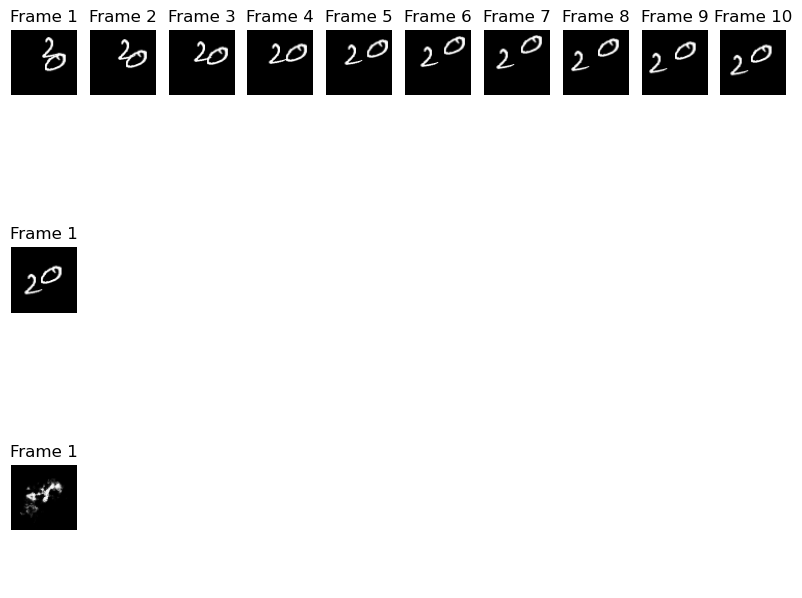

In [40]:

# Construct a figure on which we will visualize the images.
# input_sequence_number = 10 
# output_sequence_number = 2
fig, axes = plt.subplots(3, input_sequence_number, figsize=(10, 8))
for item in axes:
    for ax in item:
        ax.axis("off")
# Plot each of the sequential images for one random data example.
for idx, item in enumerate(input_frames[1]):
    axes[0, idx].imshow(item.cpu(), cmap="gray")
    axes[0, idx].set_title(f"Frame {idx + 1}")

# Plot each of the sequential images for one random data example.
for idx, item in enumerate(target_frame[1]):
    axes[1, idx].imshow(item.cpu(), cmap="gray")
    axes[1, idx].set_title(f"Frame {idx + 1}")

# Plot each of the sequential images for one random data example.
for idx, item in enumerate(output_frame[1]):
    axes[2, idx].imshow(item.cpu(), cmap="gray")
    axes[2, idx].set_title(f"Frame {idx + 1}")

# Print information and display the figure.
print(f"Displaying frames for input 0, target 0 and predicted output 0.")
plt.show()
# (input_frames[0][4] == target_frame[0][0]).all()

# RNN

In [61]:

import torch
import torch.nn as nn

class LongTermPredictionRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LongTermPredictionRNN, self).__init__()
        self.rnn = nn.RNN(input_size=input_size, hidden_size = hidden_size, num_layers=2, batch_first=True)
        self.fc = nn.Linear(hidden_size*input_sequence_number, output_size)



    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.flatten(2)
        
        # get RNN outputs
        r_out, hidden = self.rnn(x, hidden)

        # shape output to the linear layer (batch_size, seq_length*hidden_dim)
        r_out = torch.relu(r_out.flatten(1))  

        # get final output 
        output = torch.sigmoid(self.fc(r_out))
        
        return output.view(-1, 1, 64, 64), hidden.detach()

# Assuming input size, hidden size, and output size
input_size = 64 * 64 
hidden_size = 128
output_size = 64 * 64 * output_sequence_number

# Instantiate the RNN model
rnn_model = LongTermPredictionRNN(input_size, hidden_size, output_size)

# Move the model to the specified device
rnn_model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(rnn_model.parameters(), lr=0.001)

# Print the model architecture
print(rnn_model)

# Calculate the number of parameters in the model
total_params_rnn = sum(p.numel() for p in rnn_model.parameters())
print(f'Total Number of Parameters in the RNN Model: {total_params_rnn}')


LongTermPredictionRNN(
  (rnn): RNN(4096, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=1280, out_features=4096, bias=True)
)
Total Number of Parameters in the RNN Model: 5820928


## RNN traiing loop

In [65]:

# Number of training epochs
num_epochs = 10

h0 = torch.randn(2, batch_size, hidden_size).to(device) 

# Training loop
rnn_model.train().to(device)  # Set the model to training mode
for epoch in trange(num_epochs):
    total_loss = 0.0

    for batch_idx, (input_frames, target_frame) in enumerate(train_loader):
        input_frames = input_frames.to(device)
        target_frame = target_frame.to(device)
        optimizer.zero_grad()  # Zero the gradients
        output_frame, h0 = rnn_model(input_frames, h0)  # Forward pass

        loss = criterion(output_frame, target_frame)  # Compute the loss
        # optimizer.zero_grad()
        loss.backward(retain_graph=True)  # Backward pass
        optimizer.step()  # Update weights

        total_loss += loss.item()
    h0 = h0.detach()
    # Print training loss for each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader)}')




  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:01<00:12,  1.39s/it]

Epoch [1/10], Loss: 0.016763960077589728


 20%|██        | 2/10 [00:02<00:10,  1.37s/it]

Epoch [2/10], Loss: 0.015992285277747494


 30%|███       | 3/10 [00:04<00:09,  1.38s/it]

Epoch [3/10], Loss: 0.015325288676070149


 40%|████      | 4/10 [00:05<00:08,  1.36s/it]

Epoch [4/10], Loss: 0.014700900653900837


 50%|█████     | 5/10 [00:06<00:06,  1.36s/it]

Epoch [5/10], Loss: 0.014147237384048857


 60%|██████    | 6/10 [00:08<00:05,  1.37s/it]

Epoch [6/10], Loss: 0.013628095176296302


 70%|███████   | 7/10 [00:09<00:04,  1.36s/it]

Epoch [7/10], Loss: 0.013153261167007197


 80%|████████  | 8/10 [00:10<00:02,  1.35s/it]

Epoch [8/10], Loss: 0.012728137940208153


 90%|█████████ | 9/10 [00:12<00:01,  1.36s/it]

Epoch [9/10], Loss: 0.012322245192220202


100%|██████████| 10/10 [00:13<00:00,  1.36s/it]

Epoch [10/10], Loss: 0.011951805866286955


showing samples from training samples

Displaying frames for input 0, target 0 and predicted output 0.


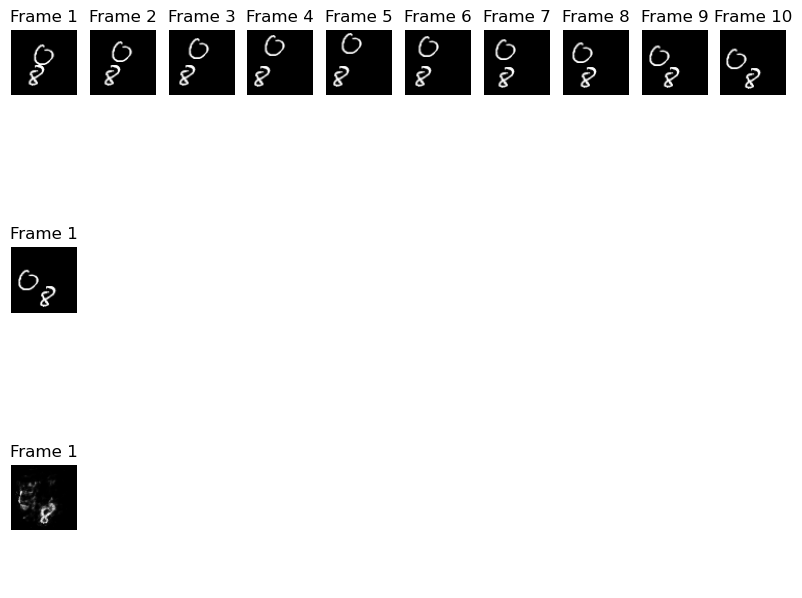

In [67]:
fig, axes = plt.subplots(3, input_sequence_number, figsize=(10, 8))
for item in axes:
    for ax in item:
        ax.axis("off")
# Plot each of the sequential images for one random data example.
for idx, item in enumerate(input_frames[1].cpu().detach()):
    axes[0, idx].imshow(item.cpu(), cmap="gray")
    axes[0, idx].set_title(f"Frame {idx + 1}")

# Plot each of the sequential images for one random data example.
for idx, item in enumerate(target_frame[1].cpu().detach()):
    axes[1, idx].imshow(item.cpu(), cmap="gray")
    axes[1, idx].set_title(f"Frame {idx + 1}")

# Plot each of the sequential images for one random data example.
for idx, item in enumerate(output_frame[1].cpu().detach()):
    axes[2, idx].imshow(item.cpu(), cmap="gray")
    axes[2, idx].set_title(f"Frame {idx + 1}")

# Print information and display the figure.
print(f"Displaying frames for input 0, target 0 and predicted output 0.")
plt.show()

## RNN Validation Loop

In [68]:
# Validation loop
rnn_model.eval()  # Set the rnn_model to evaluation mode
total_val_loss = 0.0

with torch.no_grad():
    for batch_idx, (input_frames, target_frame) in enumerate(validation_loader):
        input_frames = input_frames.to(device)
        target_frame = target_frame.to(device)
        output_frame, h0 = rnn_model(input_frames, h0)
        val_loss = criterion(output_frame, target_frame)
        total_val_loss += val_loss.item()

# Print validation loss
print(f'Validation Loss: {total_val_loss / len(validation_loader)}')

Validation Loss: 0.029180383189551292


Displaying frames for input 0, target 0 and predicted output 0.


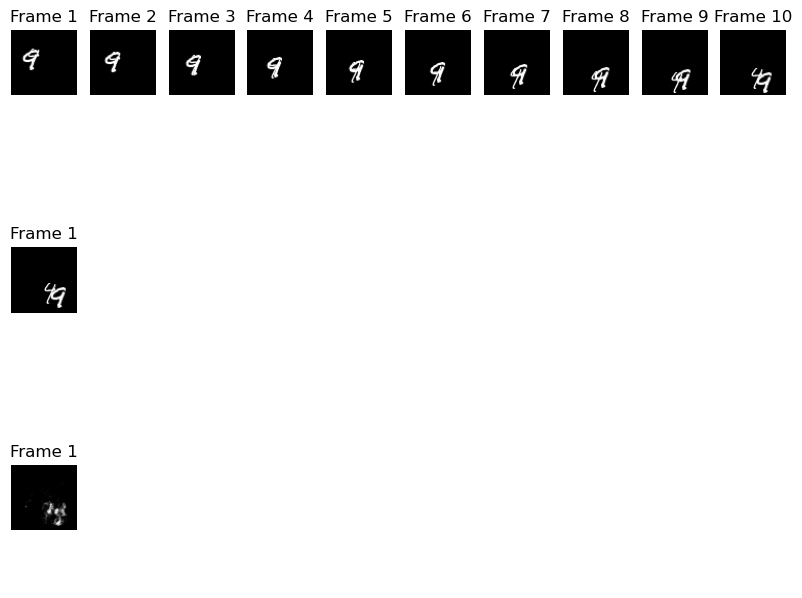

In [69]:

# Construct a figure on which we will visualize the images.
# input_sequence_number = 10 
# output_sequence_number = 2
fig, axes = plt.subplots(3, input_sequence_number, figsize=(10, 8))
for item in axes:
    for ax in item:
        ax.axis("off")
# Plot each of the sequential images for one random data example.
for idx, item in enumerate(input_frames[1]):
    axes[0, idx].imshow(item.cpu(), cmap="gray")
    axes[0, idx].set_title(f"Frame {idx + 1}")

# Plot each of the sequential images for one random data example.
for idx, item in enumerate(target_frame[1]):
    axes[1, idx].imshow(item.cpu(), cmap="gray")
    axes[1, idx].set_title(f"Frame {idx + 1}")

# Plot each of the sequential images for one random data example.
for idx, item in enumerate(output_frame[1]):
    axes[2, idx].imshow(item.cpu(), cmap="gray")
    axes[2, idx].set_title(f"Frame {idx + 1}")

# Print information and display the figure.
print(f"Displaying frames for input 0, target 0 and predicted output 0.")
plt.show()
# (input_frames[0][4] == target_frame[0][0]).all()

In [ ]:

# Calculate the number of parameters
total_params = sum(p.numel() for p in model.parameters())
print(f'Total Number of Parameters in the Model: {total_params}')
device = "cuda:0" if torch.cuda.is_available() else "cpu"
print(device)
# Code to find GPU usage
print(torch.cuda.get_device_name(0))
print('Memory Usage:')
print('Allocated:', round(torch.cuda.memory_allocated(0) / 1024 ** 3, 1), 'GB')
print('Cached: ', round(torch.cuda.memory_cached(0) / 1024 ** 3, 1), 'GB')

# LSTM

In [73]:
# RNN
import torch
import torch.nn as nn

class LongTermPredictionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LongTermPredictionLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size = hidden_size, num_layers=2, batch_first=True)
        self.fc = nn.Linear(hidden_size*input_sequence_number, output_size)



    def forward(self, x, h0, c0):
        batch_size = x.size(0)
        x = x.flatten(2)
        
        # get RNN outputs
        r_out, (h0, c0) = self.lstm(x, (h0, c0))

        # shape output to the linear layer (batch_size, seq_length*hidden_dim)
        r_out = torch.relu(r_out.flatten(1))  

        # get final output 
        output = torch.sigmoid(self.fc(r_out))
        
        return output.view(-1, 1, 64, 64), (h0.detach(), c0.detach())

# Assuming input size, hidden size, and output size
input_size = 64 * 64 
hidden_size = 128
output_size = 64 * 64 * output_sequence_number

# Instantiate the RNN model
lstm_model = LongTermPredictionLSTM(input_size, hidden_size, output_size)

# Move the model to the specified device
lstm_model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

# Print the model architecture
print(lstm_model)

# Calculate the number of parameters in the model
total_params_lstm = sum(p.numel() for p in lstm_model.parameters())
print(f'Total Number of Parameters in the RNN Model: {total_params_lstm}')


LongTermPredictionLSTM(
  (lstm): LSTM(4096, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=1280, out_features=4096, bias=True)
)
Total Number of Parameters in the RNN Model: 7542784


  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [00:01<00:14,  1.56s/it]

Epoch [1/10], Loss: 0.01502285910989042


 20%|██        | 2/10 [00:03<00:12,  1.53s/it]

Epoch [2/10], Loss: 0.014599909313235206


 30%|███       | 3/10 [00:04<00:10,  1.50s/it]

Epoch [3/10], Loss: 0.014200464756065628


 40%|████      | 4/10 [00:05<00:08,  1.48s/it]

Epoch [4/10], Loss: 0.013825174820446989


 50%|█████     | 5/10 [00:07<00:07,  1.49s/it]

Epoch [5/10], Loss: 0.013474205203911164


 60%|██████    | 6/10 [00:08<00:05,  1.48s/it]

Epoch [6/10], Loss: 0.013125578804916016


 70%|███████   | 7/10 [00:10<00:04,  1.48s/it]

Epoch [7/10], Loss: 0.012803049226129076


 80%|████████  | 8/10 [00:11<00:02,  1.47s/it]

Epoch [8/10], Loss: 0.012483302835255755


 90%|█████████ | 9/10 [00:13<00:01,  1.48s/it]

Epoch [9/10], Loss: 0.012177529100169596


100%|██████████| 10/10 [00:14<00:00,  1.48s/it]

Epoch [10/10], Loss: 0.011892648498292389


Displaying frames for input 0, target 0 and predicted output 0.


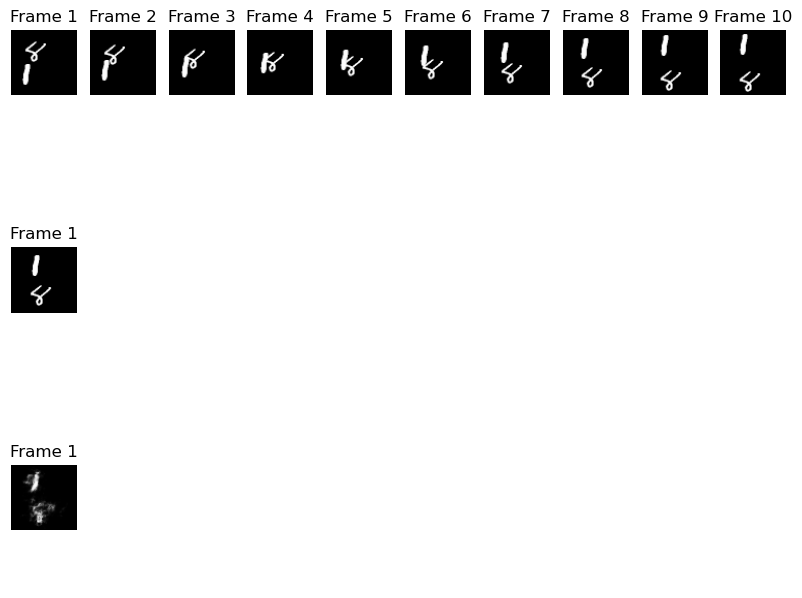

Validation Loss: 0.02926730932367425
Displaying frames for input 0, target 0 and predicted output 0.


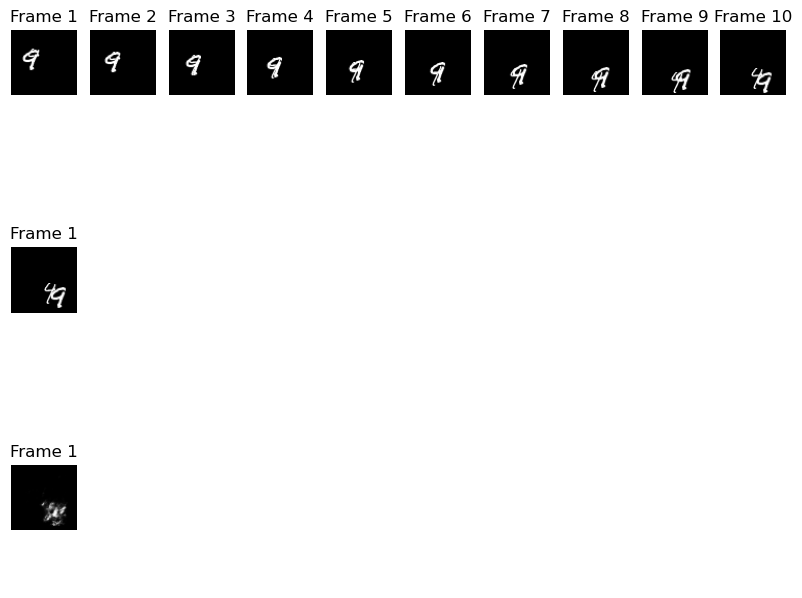

In [77]:

# Number of training epochs
num_epochs = 10

h0 = torch.randn(2, batch_size, hidden_size).to(device) 
c0 = torch.randn(2, batch_size, hidden_size).to(device) 

# Training loop
lstm_model.train().to(device)  # Set the model to training mode
for epoch in trange(num_epochs):
    total_loss = 0.0

    for batch_idx, (input_frames, target_frame) in enumerate(train_loader):
        input_frames = input_frames.to(device)
        target_frame = target_frame.to(device)
        optimizer.zero_grad()  # Zero the gradients
        output_frame, (h0, c0) = lstm_model(input_frames, h0, c0)  # Forward pass

        loss = criterion(output_frame, target_frame)  # Compute the loss
        # optimizer.zero_grad()
        loss.backward(retain_graph=True)  # Backward pass
        optimizer.step()  # Update weights

        total_loss += loss.item()
    # Print training loss for each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {total_loss / len(train_loader)}')

# Validation loop
rnn_model.eval()  # Set the rnn_model to evaluation mode
total_val_loss = 0.0


fig, axes = plt.subplots(3, input_sequence_number, figsize=(10, 8))
for item in axes:
    for ax in item:
        ax.axis("off")
# Plot each of the sequential images for one random data example.
for idx, item in enumerate(input_frames[1].cpu().detach()):
    axes[0, idx].imshow(item.cpu(), cmap="gray")
    axes[0, idx].set_title(f"Frame {idx + 1}")

# Plot each of the sequential images for one random data example.
for idx, item in enumerate(target_frame[1].cpu().detach()):
    axes[1, idx].imshow(item.cpu(), cmap="gray")
    axes[1, idx].set_title(f"Frame {idx + 1}")

# Plot each of the sequential images for one random data example.
for idx, item in enumerate(output_frame[1].cpu().detach()):
    axes[2, idx].imshow(item.cpu(), cmap="gray")
    axes[2, idx].set_title(f"Frame {idx + 1}")

# Print information and display the figure.
print(f"Displaying frames for input 0, target 0 and predicted output 0.")
plt.show()


with torch.no_grad():
    for batch_idx, (input_frames, target_frame) in enumerate(validation_loader):
        input_frames = input_frames.to(device)
        target_frame = target_frame.to(device)
        output_frame, (h0, c0) = lstm_model(input_frames, h0, c0)
        val_loss = criterion(output_frame, target_frame)
        total_val_loss += val_loss.item()

# Print validation loss
print(f'Validation Loss: {total_val_loss / len(validation_loader)}')


fig, axes = plt.subplots(3, input_sequence_number, figsize=(10, 8))
for item in axes:
    for ax in item:
        ax.axis("off")
# Plot each of the sequential images for one random data example.
for idx, item in enumerate(input_frames[1].cpu().detach()):
    axes[0, idx].imshow(item.cpu(), cmap="gray")
    axes[0, idx].set_title(f"Frame {idx + 1}")

# Plot each of the sequential images for one random data example.
for idx, item in enumerate(target_frame[1].cpu().detach()):
    axes[1, idx].imshow(item.cpu(), cmap="gray")
    axes[1, idx].set_title(f"Frame {idx + 1}")

# Plot each of the sequential images for one random data example.
for idx, item in enumerate(output_frame[1].cpu().detach()):
    axes[2, idx].imshow(item.cpu(), cmap="gray")
    axes[2, idx].set_title(f"Frame {idx + 1}")

# Print information and display the figure.
print(f"Displaying frames for input 0, target 0 and predicted output 0.")
plt.show()


# CNN-LSTM

In [139]:
# Assuming input size, hidden size, and output size
in_channels = input_sequence_number
out_channels = 10
input_size = 64 * 64 
hidden_size = 128
output_size = 64 * 64 * output_sequence_number
# Original ConvLSTM cell as proposed by Shi et al.
class ConvLSTMCell(nn.Module):

    def __init__(self, in_channels, out_channels, 
    kernel_size, padding, activation, frame_size):

        super(ConvLSTMCell, self).__init__()  

        if activation == "tanh":
            self.activation = torch.tanh 
        elif activation == "relu":
            self.activation = torch.relu
        
        # Idea adapted from https://github.com/ndrplz/ConvLSTM_pytorch
        self.conv = nn.Conv2d(
            in_channels=in_channels + out_channels, 
            out_channels=4 * out_channels, 
            kernel_size=kernel_size, 
            padding=padding)           

        # Initialize weights for Hadamard Products
        self.W_ci = nn.Parameter(torch.Tensor(out_channels, *frame_size))
        self.W_co = nn.Parameter(torch.Tensor(out_channels, *frame_size))
        self.W_cf = nn.Parameter(torch.Tensor(out_channels, *frame_size))

    def forward(self, X, H_prev, C_prev):

        # Idea adapted from https://github.com/ndrplz/ConvLSTM_pytorch
        conv_output = self.conv(torch.cat([X, H_prev], dim=1))

        # Idea adapted from https://github.com/ndrplz/ConvLSTM_pytorch
        i_conv, f_conv, C_conv, o_conv = torch.chunk(conv_output, chunks=4, dim=1)

        input_gate = torch.sigmoid(i_conv + self.W_ci * C_prev )
        forget_gate = torch.sigmoid(f_conv + self.W_cf * C_prev )

        # Current Cell output
        C = forget_gate*C_prev + input_gate * self.activation(C_conv)

        output_gate = torch.sigmoid(o_conv + self.W_co * C )

        # Current Hidden State
        H = output_gate * self.activation(C)

        return H, C


class ConvLSTM(nn.Module):

    def __init__(self, in_channels, out_channels, 
    kernel_size, padding, activation, frame_size):

        super(ConvLSTM, self).__init__()

        self.out_channels = out_channels

        # We will unroll this over time steps
        self.convLSTMcell = ConvLSTMCell(in_channels, out_channels, 
        kernel_size, padding, activation, frame_size)

    def forward(self, X):

        # X is a frame sequence (batch_size, num_channels, seq_len, height, width)

        # Get the dimensions
        batch_size, _, seq_len, height, width = X.size()

        # Initialize output
        output = torch.zeros(batch_size, self.out_channels, seq_len, height, width, device=device)
        
        # Initialize Hidden State
        H = torch.zeros(batch_size, self.out_channels, height, width, device=device)

        # Initialize Cell Input
        C = torch.zeros(batch_size,self.out_channels, height, width, device=device)

        # Unroll over time steps
        for time_step in range(seq_len):

            H, C = self.convLSTMcell(X[:,:,time_step], H, C)

            output[:,:, time_step] = H

        return output
    

class Seq2Seq(nn.Module):

    def __init__(self, num_channels, num_kernels, kernel_size, padding, 
    activation, frame_size, num_layers):

        super(Seq2Seq, self).__init__()

        self.sequential = nn.Sequential()

        # Add First layer (Different in_channels than the rest)
        self.sequential.add_module(
            "convlstm1", ConvLSTM(
                in_channels=num_channels, out_channels=num_kernels,
                kernel_size=kernel_size, padding=padding, 
                activation=activation, frame_size=frame_size)
        )

        self.sequential.add_module(
            "batchnorm1", nn.BatchNorm3d(num_features=num_kernels)
        ) 

        # Add rest of the layers
        for l in range(2, num_layers+1):

            self.sequential.add_module(
                f"convlstm{l}", ConvLSTM(
                    in_channels=num_kernels, out_channels=num_kernels,
                    kernel_size=kernel_size, padding=padding, 
                    activation=activation, frame_size=frame_size)
                )
                
            self.sequential.add_module(
                f"batchnorm{l}", nn.BatchNorm3d(num_features=num_kernels)
                ) 

        # Add Convolutional Layer to predict output frame
        self.conv = nn.Conv2d(
            in_channels=num_kernels, out_channels=num_channels,
            kernel_size=kernel_size, padding=padding)

    def forward(self, X):

        # Forward propagation through all the layers
        output = self.sequential(X)

        # Return only the last output frame
        output = self.conv(output[:,:,-1])
        
        return nn.Sigmoid()(output)

In [140]:
# Get a batch
input, _ = next(iter(validation_loader))

# Reverse process before displaying
input = input.cpu().numpy() * 255.0     
print(input.shape)
for video in input[:3]:          # Loop over videos
    with io.BytesIO() as gif:
        imageio.mimsave(gif,video.astype(np.uint8),"GIF", duration=1)
        display(HBox([widgets.Image(value=gif.getvalue())]))

(16, 10, 64, 64)


In [141]:
# The input video frames are grayscale, thus single channel
model = Seq2Seq(num_channels=1, num_kernels=64, 
kernel_size=(3, 3), padding=(1, 1), activation="relu", 
frame_size=(64, 64), num_layers=3).to(device)

optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Binary Cross Entropy, target pixel values either 0 or 1
criterion = nn.BCELoss(reduction='sum')

In [144]:
num_epochs = 20

for epoch in trange(1, num_epochs+1):
    
    train_loss = 0                                                 
    model.train()                                                  
    for batch_num, (input, target) in enumerate(train_loader, 1):  
        input = input.unsqueeze(1).to(device)
        target = target.to(device)
        output = model(input.to(device))                                     
        loss = criterion(output.flatten(), target.flatten())       
        loss.backward()                                            
        optimizer.step()                                               
        optimizer.zero_grad()                                           
        train_loss += loss.item()                                 
    train_loss /= len(train_loader.dataset)                       

    val_loss = 0                                                 
    model.eval()                                                   
    with torch.no_grad():                                          
        for input, target in validation_loader:                          
            input = input.unsqueeze(1).to(device)
            target = target.to(device)
            output = model(input)                                   
            loss = criterion(output.flatten(), target.flatten())   
            val_loss += loss.item()                                
    val_loss /= len(validation_loader.dataset)                            

    print("Epoch:{} Training Loss:{:.2f} Validation Loss:{:.2f}\n".format(
        epoch, train_loss, val_loss))

  5%|▌         | 1/20 [02:34<48:48, 154.11s/it]

Epoch:1 Training Loss:295.88 Validation Loss:282.58



 10%|█         | 2/20 [05:09<46:28, 154.91s/it]

Epoch:2 Training Loss:285.38 Validation Loss:276.13



 15%|█▌        | 3/20 [07:44<43:55, 155.04s/it]

Epoch:3 Training Loss:277.00 Validation Loss:270.59



 20%|██        | 4/20 [10:19<41:21, 155.10s/it]

Epoch:4 Training Loss:270.55 Validation Loss:265.45



 25%|██▌       | 5/20 [12:55<38:47, 155.17s/it]

Epoch:5 Training Loss:264.99 Validation Loss:262.09



 30%|███       | 6/20 [15:30<36:13, 155.27s/it]

Epoch:6 Training Loss:262.05 Validation Loss:257.23



 35%|███▌      | 7/20 [18:06<33:39, 155.32s/it]

Epoch:7 Training Loss:257.02 Validation Loss:254.74



 40%|████      | 8/20 [20:41<31:03, 155.30s/it]

Epoch:8 Training Loss:253.50 Validation Loss:253.32



 45%|████▌     | 9/20 [23:17<28:29, 155.41s/it]

Epoch:9 Training Loss:249.88 Validation Loss:250.46



 50%|█████     | 10/20 [25:52<25:53, 155.38s/it]

Epoch:10 Training Loss:246.76 Validation Loss:250.10



 55%|█████▌    | 11/20 [28:27<23:19, 155.45s/it]

Epoch:11 Training Loss:246.23 Validation Loss:249.88



 60%|██████    | 12/20 [31:03<20:44, 155.56s/it]

Epoch:12 Training Loss:242.10 Validation Loss:248.02



 65%|██████▌   | 13/20 [33:38<18:06, 155.20s/it]

Epoch:13 Training Loss:239.62 Validation Loss:241.55



 70%|███████   | 14/20 [36:11<15:28, 154.70s/it]

Epoch:14 Training Loss:237.12 Validation Loss:243.61



 75%|███████▌  | 15/20 [38:46<12:53, 154.73s/it]

Epoch:15 Training Loss:235.92 Validation Loss:241.83



 80%|████████  | 16/20 [41:22<10:19, 154.97s/it]

Epoch:16 Training Loss:232.92 Validation Loss:238.77



 85%|████████▌ | 17/20 [43:57<07:45, 155.11s/it]

Epoch:17 Training Loss:231.21 Validation Loss:240.99



 90%|█████████ | 18/20 [46:33<05:10, 155.24s/it]

Epoch:18 Training Loss:229.28 Validation Loss:238.44



 95%|█████████▌| 19/20 [49:08<02:35, 155.33s/it]

Epoch:19 Training Loss:231.20 Validation Loss:240.73



100%|██████████| 20/20 [51:43<00:00, 155.20s/it]

Epoch:20 Training Loss:226.76 Validation Loss:237.10



Displaying frames for input 0, target 0 and predicted output 0.


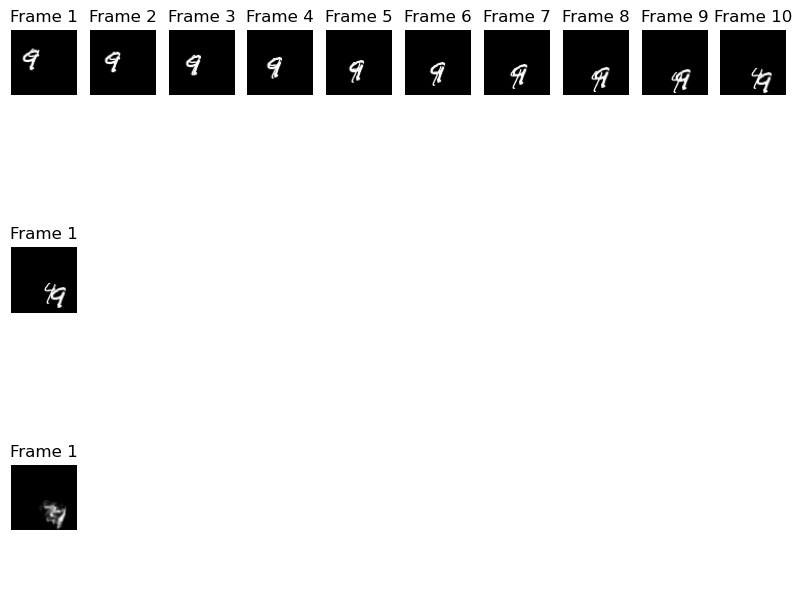

In [146]:
fig, axes = plt.subplots(3, input_sequence_number, figsize=(10, 8))
for item in axes:
    for ax in item:
        ax.axis("off")
# Plot each of the sequential images for one random data example.
for idx, item in enumerate(input[1, 0].cpu().detach()):
    axes[0, idx].imshow(item.cpu(), cmap="gray")
    axes[0, idx].set_title(f"Frame {idx + 1}")

# Plot each of the sequential images for one random data example.
for idx, item in enumerate(target[1].cpu().detach()):
    axes[1, idx].imshow(item.cpu(), cmap="gray")
    axes[1, idx].set_title(f"Frame {idx + 1}")

# Plot each of the sequential images for one random data example.
for idx, item in enumerate(output[1].cpu().detach()):
    axes[2, idx].imshow(item.cpu(), cmap="gray")
    axes[2, idx].set_title(f"Frame {idx + 1}")

# Print information and display the figure.
print(f"Displaying frames for input 0, target 0 and predicted output 0.")
plt.show()


# simple CNN-LSTM

In [57]:
import torch.nn.functional as F
from torch.autograd import Variable



FRAME_SIZE = 64
class CNN(nn.Module):
    
    def __init__(self, input_height, input_width, input_channels, 
                 output_channels, 
                 conv_kernel_size, conv_stride, conv_padding,
                 pool_size):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, output_channels, 
                               kernel_size=conv_kernel_size, 
                               stride=conv_stride, 
                               padding=conv_padding)
        self.relu1 = nn.ReLU()
        self.output_height = input_height // pool_size
        self.output_width = input_width // pool_size
        self.output_channels = output_channels
        self.pool_size = pool_size
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu1(x)
        x = F.max_pool2d(x, self.pool_size)
        x = x.view(x.size(0), self.output_channels * self.output_height * self.output_width)
        return x

cnn = CNN(input_height=FRAME_SIZE, input_width=FRAME_SIZE, #image is 64*64 
          input_channels=1, #the frames are gray scale therefore one channel only
          output_channels = 2, 
          conv_kernel_size=2, conv_stride=1, conv_padding=1, pool_size=2)
print(cnn)

# size debugging
print("--- size debugging ---")
inp = Variable(torch.randn(batch_size, 1, FRAME_SIZE, FRAME_SIZE))
out = cnn(inp)
print(out.size())


class CNNLSTM(nn.Module):
    
    def __init__(self, image_size, input_channels, output_channels, 
                 conv_kernel_size, conv_stride, conv_padding, pool_size, 
                 seq_length, hidden_size, num_layers, output_size):
        super(CNNLSTM, self).__init__()
        # capture variables
        self.num_layers = num_layers
        self.seq_length = seq_length
        self.image_size = image_size
        self.output_channels = output_channels
        self.hidden_size = hidden_size
        self.lstm_input_size = output_channels * (image_size // pool_size) ** 2
        # define network layers
        self.cnn = CNN(image_size, image_size, input_channels, output_channels, 
                       conv_kernel_size, conv_stride, conv_padding, pool_size)
        self.lstm = nn.LSTM(self.lstm_input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        self.softmax = nn.Softmax()
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):

        h0 = (Variable(torch.randn(self.num_layers, x.size(0), self.hidden_size, device=device)),
                Variable(torch.randn(self.num_layers, x.size(0), self.hidden_size, device=device)))
        
        cnn_out = []
        for i in range(self.seq_length):
            cnn_out.append(self.cnn(x[:, i, :, :, :]))
        x = torch.cat(cnn_out, dim=1).view(-1, self.seq_length, self.lstm_input_size)
        x, h0 = self.lstm(x, h0)
        x = self.fc(x[:, -1, :])
        x = self.sigmoid(x)
        return x.view(x.size(0), output_sequence_number,FRAME_SIZE,FRAME_SIZE)        

model = CNNLSTM(image_size=FRAME_SIZE, input_channels=1, 
                output_channels=2, conv_kernel_size=2, conv_stride=1, conv_padding=1, pool_size=3,
                seq_length=input_sequence_number, hidden_size=128, num_layers=1, 
                output_size=FRAME_SIZE*FRAME_SIZE*output_sequence_number)
model.to(device=device)
print(model)

# size debugging
print("--- size debugging ---")
inp = Variable(torch.randn(batch_size, input_sequence_number, 1, FRAME_SIZE, FRAME_SIZE, device=device))
out = model(inp)
print(out.size())

CNN(
  (conv1): Conv2d(1, 2, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
)
--- size debugging ---
torch.Size([16, 2048])
CNNLSTM(
  (cnn): CNN(
    (conv1): Conv2d(1, 2, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
    (relu1): ReLU()
  )
  (lstm): LSTM(882, 128, batch_first=True)
  (fc): Linear(in_features=128, out_features=4096, bias=True)
  (softmax): Softmax(dim=None)
  (sigmoid): Sigmoid()
)
--- size debugging ---
torch.Size([16, 1, 64, 64])


In [60]:
# loss_fn = nn.CrossEntropyLoss()
from IPython.display import clear_output
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

from sklearn.metrics import accuracy_score, confusion_matrix
def compute_accuracy(pred_var, true_var):
    if torch.cuda.is_available():
        ypred = pred_var.cpu().data.numpy()
        ytrue = true_var.cpu().data.numpy()
    else:
        ypred = pred_var.data.numpy()
        ytrue = true_var.data.numpy()
        accuracy_score(torch.ones_like(ypred), torch.ones_like(ypred))
    return accuracy_score(ypred, ytrue)

num_epochs = 20

for epoch in trange(1, num_epochs+1):
    
    train_loss = 0                                                 
    model.train()
    train_loss, train_acc = 0., 0.                                                  
    for batch_num, (input, target) in enumerate(train_loader, 1):  
        input = input.unsqueeze(2).to(device)
        target = target.to(device)
                        
        # forward
        output = model(input)    
                   
        # initialize gradients
        optimizer.zero_grad()
        # backward
        loss = loss_fn(output.flatten(), target.flatten())
        loss.backward()

        train_loss += loss.item()
        
        _, ybatch_ = output.max(1)
        # train_acc += compute_accuracy(ybatch_, target)
        
        optimizer.step()

    train_loss /= len(train_loader.dataset)
    # train_acc /= len(train_loader.dataset)
    val_loss = 0                                                 
    # model.eval()                                                   
    with torch.no_grad():                                          
        for input_val, target_val in validation_loader:                          
            input_val = input_val.unsqueeze(2).to(device)
            target_val = target_val.to(device)
            output_val = model(input_val)                                   
            loss = loss_fn(output_val, target_val)
            val_loss += loss.item()                                
    val_loss /= len(validation_loader.dataset)                            
    
    clear_output(wait=True)
    print("Epoch:{} Training Loss:{:.5f} Validation Loss:{:.5f}\n".format(epoch, train_loss, val_loss))
    


100%|██████████| 20/20 [00:56<00:00,  2.84s/it]

Epoch:20 Training Loss:0.00110 Validation Loss:0.00143



Displaying frames for input 0, target 0 and predicted output 0.


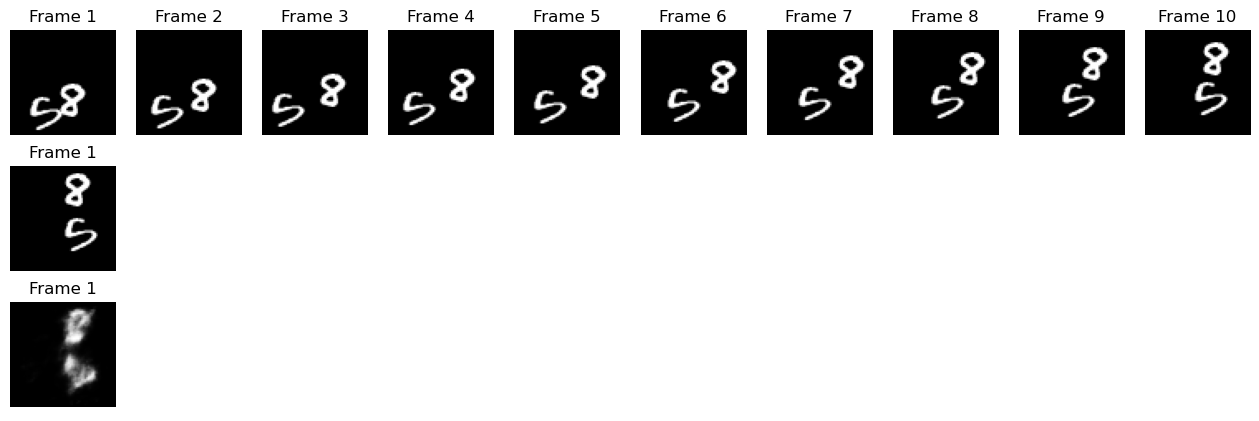

Displaying frames for input 0, target 0 and predicted output 0.


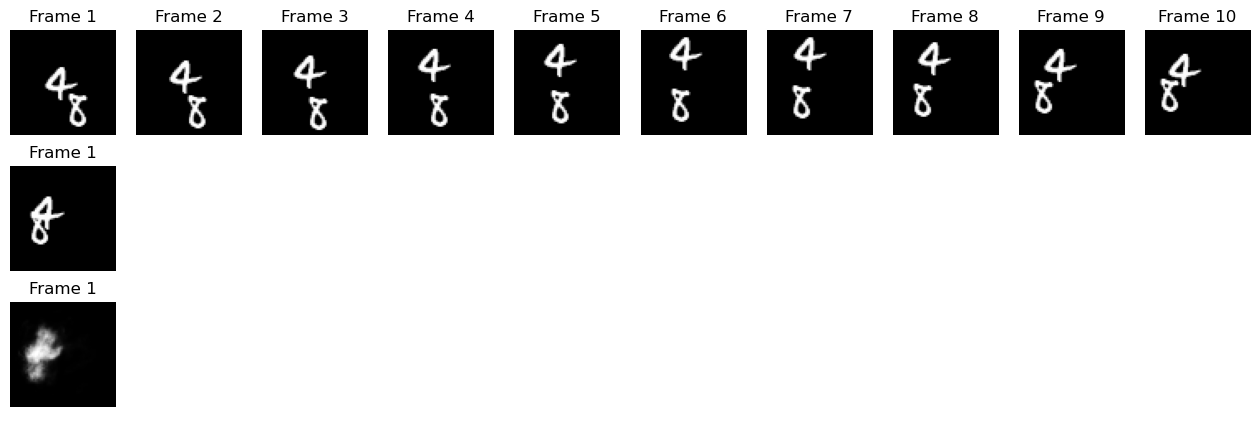

In [61]:
fig, axes = plt.subplots(3, input_sequence_number, figsize=(16, 5))
for item in axes:
    for ax in item:
        ax.axis("off")
# Plot each of the sequential images for one random data example.
for idx, item in enumerate(input[1, :, 0].cpu().detach()):
    axes[0, idx].imshow(item.cpu(), cmap="gray")
    axes[0, idx].set_title(f"Frame {idx + 1}")

# Plot each of the sequential images for one random data example.
for idx, item in enumerate(target[1].cpu().detach()):
    axes[1, idx].imshow(item.cpu(), cmap="gray")
    axes[1, idx].set_title(f"Frame {idx + 1}")

# Plot each of the sequential images for one random data example.
for idx, item in enumerate(output[1].cpu().detach()):
    axes[2, idx].imshow(item.cpu(), cmap="gray")
    axes[2, idx].set_title(f"Frame {idx + 1}")

# Print information and display the figure.
print(f"Displaying frames for input 0, target 0 and predicted output 0.")
plt.show()


fig, axes = plt.subplots(3, input_sequence_number, figsize=(16, 5))
for item in axes:
    for ax in item:
        ax.axis("off")
# Plot each of the sequential images for one random data example.
for idx, item in enumerate(input_val[1, :, 0].cpu().detach()):
    axes[0, idx].imshow(item.cpu(), cmap="gray")
    axes[0, idx].set_title(f"Frame {idx + 1}")

# Plot each of the sequential images for one random data example.
for idx, item in enumerate(target_val[1].cpu().detach()):
    axes[1, idx].imshow(item.cpu(), cmap="gray")
    axes[1, idx].set_title(f"Frame {idx + 1}")

# Plot each of the sequential images for one random data example.
for idx, item in enumerate(output_val[1].cpu().detach()):
    axes[2, idx].imshow(item.cpu(), cmap="gray")
    axes[2, idx].set_title(f"Frame {idx + 1}")

# Print information and display the figure.
print(f"Displaying frames for input 0, target 0 and predicted output 0.")

plt.show()
